## Retrieving snowfall rates from WSR-88D using simple relations

Scott Collis Argonne National Laboratory

@cyclogenesis_au Twitter

scollis@anl.gov


First a little background. Weather radar measures equivalent reflectivity factor, $Z_e$ which is the 6th moment of te PDF of drop sizes ($\int{nD^6dD}$). Marshall and Palmer related $Z_e$ to rainfall rate back in 1948 [1] and Marshall and Gunn created the first snowfall reflectivity relation in 1956 [2]. The paper by Bukovčić et al [3] provides a very nice overview of snowfall reflectivity relations and is the main source for this notebook. **It should be noted that S-Z relations relate to the Snow Water Equivalent (SWE)** and not the snow accumulation rate in inches. SWE is the amount of liquid (in mm) if you melted snow down. For example, if we had 10mm of snow and the SWE ration was 10:1 we would melt it down to 1mm of water. This notebook explores those relations and retrieves snowrate from the recent Boston Blizzard. 

[1] https://journals.ametsoc.org/view/journals/atsc/5/4/1520-0469_1948_005_0165_tdorws_2_0_co_2.xml
[2] https://journals.ametsoc.org/view/journals/apme/57/1/jamc-d-17-0090.1.xml
[3] https://journals.ametsoc.org/view/journals/apme/57/1/jamc-d-17-0090.1.xml

In [1]:
# First lets get set up!
from os import path
import nexradaws
import time
import tempfile
import os
import shutil
import pyart
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.feature import NaturalEarthFeature
import matplotlib.colors as colors


import numpy as np

import pytz
from copy import deepcopy

from math import atan2 as atan2
import warnings

%matplotlib inline

#Scale bar code. Because I like scale bars
#This code courtesy and gratefully received from Tim Lang @tjlang on twitter

def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
 
 
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 4.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)
 


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



First lets just get a feel for Z Snow relations

In [2]:
#Create an array of reflectivity factors in dBZ from 10 to 60 dBZ
zf = np.linspace(10,60., 100)

#Convert to linear reflectivity ALWAYS DO THIS
z_lin = 10.0**(zf/10.)

#Lets look at three relations from [3]
snow_z = (z_lin/110.)**(1./2.)  #a=200 b 2
snow_midwest = (z_lin/180.)**(1./2.)  #a=200 b 2
snow_szyrmer = (z_lin/494.)**(1./1.44)  #a=200 b 2



Now lets plot them.. First, errors are worse the stronger the radar signal! Second, one might think "boy you need a real high Z for a certain snow rate!" Remember this is for SWE.. 

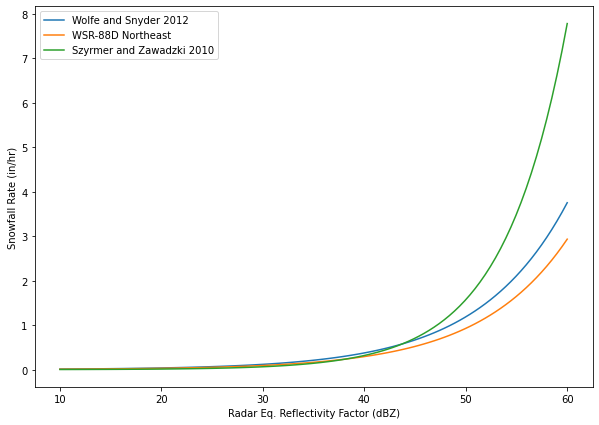

In [3]:
#25.4 for mm to inches.. folks in the USA like inches.

ff=plt.figure(figsize=[10,7])
plt.plot(zf, snow_z/25.4, label='Wolfe and Snyder 2012')
plt.plot(zf, snow_midwest/25.4, label='WSR-88D Northeast')
plt.plot(zf, snow_szyrmer/25.4, label='Szyrmer and Zawadzki 2010')
plt.xlabel('Radar Eq. Reflectivity Factor (dBZ)')
plt.ylabel('Snowfall Rate (in/hr)')
plt.legend()

Thank you to Dr Randy Chase (@DopplerChase on twitter and Postdoc at AI2ES at OU) for point out the SWE.. Lets assume a ratio of 8.5 mm to 1mm snow depth to water:

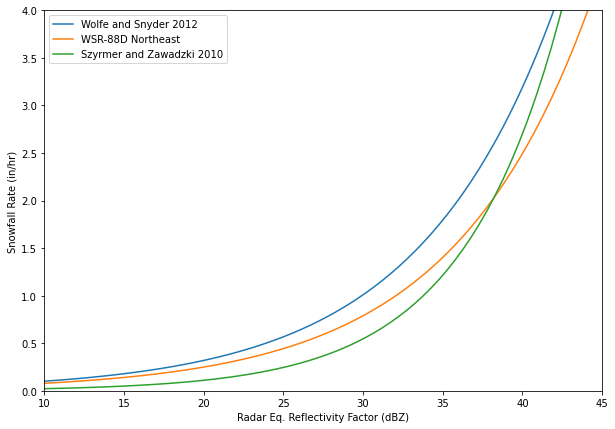

In [4]:
#25.4 for mm to inches.. folks in the USA like inches.
SWE_R = 8.5
ff=plt.figure(figsize=[10,7])
plt.plot(zf, SWE_R * snow_z/25.4, label='Wolfe and Snyder 2012')
plt.plot(zf, SWE_R * snow_midwest/25.4, label='WSR-88D Northeast')
plt.plot(zf, SWE_R * snow_szyrmer/25.4, label='Szyrmer and Zawadzki 2010')
plt.xlabel('Radar Eq. Reflectivity Factor (dBZ)')
plt.ylabel('Snowfall Rate (in/hr)')
plt.ylim([0,4])
plt.xlim([10,45])
plt.legend()

Ok.. This comports with what us weather geeks know from radar gazing.. 35dBZ = Puking down. 

Now.. DATA!

Here is some code I wrote long ago that needs refining and at least documenting

In [5]:
#https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date/32237949
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))


# This is a VERY LAZY function. 
#No testing and if it gets a file Py-ART can not read it will fail, ungracefully

#Function to pull a radar file from AWS

def get_my_radar(connex, site, this_datetime):
    tlocation = tempfile.mkdtemp()
    these_scans = connex.get_avail_scans(this_datetime.year,this_datetime.month, this_datetime.day, site)
    these_times = [scan.scan_time for scan in these_scans]
    targ = this_datetime
    
    #Need to clean
    these_good_scans = []
    these_good_times = []
    for i in range(len(these_scans)):
        if these_times[i] is not None:
            these_good_times.append(these_times[i])
            these_good_scans.append(these_scans[i])
    
    print(len(these_good_scans), len(these_good_times))

    this_nearest_time = nearest(these_good_times, targ)
    this_index = these_good_times.index(this_nearest_time)
    lcn = tlocation
    localfiles = conn.download(these_good_scans[this_index],lcn)
    return pyart.io.read(localfiles.success[0].filepath)

Connect to the CLOUD! :) FYI nexradaws is pip installable from anaconds

In [6]:
conn = nexradaws.NexradAwsInterface()

In [7]:
#Lets just repeat this here:
SWE_ratio=8.5

In [8]:
#Create a date time object for the height of the blizzard!
#It needs to be time zone aware
snow_time = datetime(2022, 1, 29, 19, 55, 0).replace(tzinfo=pytz.UTC) 

#If you want the latest use: datetime.utcnow()

In [9]:
#And like magic, grab the radar file from the Boston WSR-88D
radar_site = 'KBOX'
radar = get_my_radar(conn, radar_site, snow_time)

256 256
Downloaded KBOX20220129_195421_V06
1 out of 1 files downloaded...0 errors


Now, the magic of Py-ART is simple moment based arethmetic is easy and once you add a field all other functions work magically!

In [10]:
#Grab a COPY of the reflectivty data from the radar file. 
snow_z = radar.fields['reflectivity']['data'].copy()

#Convert it from dB to linear units ALWAYS DO THIS!
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
    
#Apply the Z-S relation, in this case the WSR-88D Northeast relation
snow_z = SWE_ratio * (z_lin/120.)**(1./2.)  #a=120 b 2

#Add the field back to the radar. Use reflectivity as a template
radar.add_field_like('reflectivity', 'snow_z',  snow_z, replace_existing = True)

#Update units and metadata
radar.fields['snow_z']['units'] = 'mm/h'
radar.fields['snow_z']['standard_name'] = 'snowfall_rate'
radar.fields['snow_z']['long_name'] = 'snowfall_rate_from_z'
radar.fields['snow_z']['valid_min'] = 0
radar.fields['snow_z']['valid_max'] = 500



Cool Beans! Now we have a WSR-88D volume with snow rates. Lets use Py-ART to make a plot using Matplotlib and Cartopy.

Lets roll this onto a nifty function

In [11]:
def do_my_plot(iradar, smax=45, app='', outdir=None):
    
    #Use this line if you want a log colormap
    norm = None #colors.LogNorm(vmin=0.1, vmax=15)
    
    #Where you want the map centered
    centerlat = 42.0
    centerlon = -70.5
    
    #delta lat lon degrees
    window = 2
    locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]
    
    #Set up the figure
    myf = plt.figure(figsize=[10,10])
    
    #We are going FULL CUSTOM.. This sets up the map panel
    map_panel_axes = [0.05, 0.05, .8, .8]
    
    #Add the map axes. Wse the Platte Carree projection. 
    ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

    #Create a radar display.. this makes Py-ART do a bunch of calcs for radar -> Cartesian coords
    myd = pyart.graph.RadarMapDisplay(iradar)
    
    #Plot a PPI, lowest tilt. Use the Homeyer CVD friendly colormap. Range between zere and smax mm/hr
    #Skip the bells and whistles, we will roll our own (embelish)
    myd.plot_ppi_map('snow_z', 0, vmin=0, vmax=smax, ax=ax, embelish=False, colorbar_flag=False,
                    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                    norm=norm)

    #Throw on some gridlines
    gl = ax.gridlines(draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False

    #Grab a high res coast
    coast = NaturalEarthFeature(category='physical', scale='10m',
                                edgecolor='black', name='coastline')

    #add the coast and state boundaries
    ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
    ax.add_feature(coast, facecolor='none', edgecolor='black')
    
    #Zoom the plot
    plt.xlim(locbox[0], locbox[1])
    plt.ylim(locbox[2], locbox[3])

    #Add a scale bar, code at the top of the notebook. Thanks Dr Tim Lang from NASA Marshall
    add_scale_line(100.0, ax, projection=ccrs.PlateCarree(), 
                   color='black', linewidth=3,
                  fontsize=20,
                  fontweight='bold')

    #Throw on a colorbar
    cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8)
    pos = cbar.ax.get_position()
    cbar.ax.set_aspect('auto')
    
    #Ok! Folks from the USA like inches.. So make a twin axis for the colorbar and scale to inches
    cax2 = cbar.ax.twinx()
    cax2.set_ylim([0,smax/25.4])
    pos.x0 +=0.05
    cbar.ax.set_position(pos)
    cax2.set_position(pos)

    #Add the text plus any appended text using app keyword.
    cax2.text(2.3,(smax/25.4)/2. -.5,'NEXRAD inst. Snow Rate (in/h) ' + app,rotation=90)
    cax2.text(-1.8,(smax/25.4)/2. -.5,'NEXRAD inst. Snow Rate (mm/h) ' + app,rotation=90)
    
    #This deals with filename formatting
    ff = time.strptime(iradar.time['units'][14:], '%Y-%m-%dT%H:%M:%SZ')
    strform = time.strftime('%Y%m%d-%H%M%S',ff)
    print(strform)
    if outdir is None:
        base_file = path.expanduser('~') + '/' + strform #dumps in your home dir
    else:
        base_file = outdir + strform
    
    #Save away! Oh and gets rid of transparency.. Tranparency makes animated gifs look odd
    plt.savefig(base_file+'snow.png', facecolor='white', transparent=False)


Phew! That was a lot.. but its done now.. Lets take it for a spin!

/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


20220129-195421


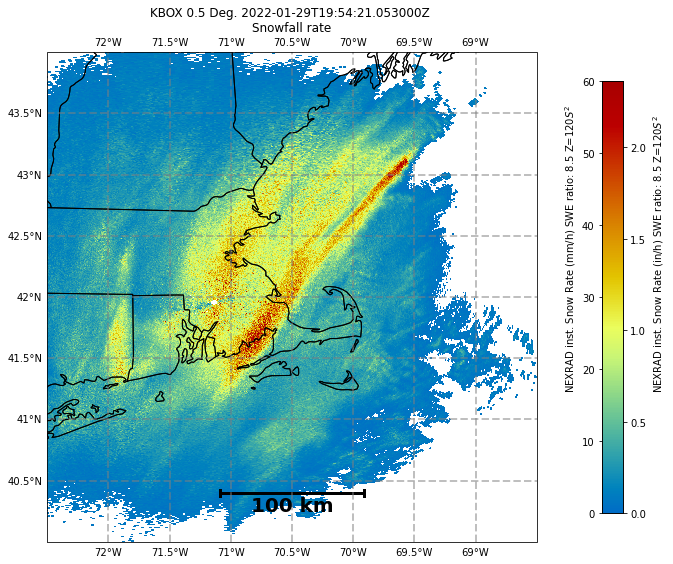

In [12]:
do_my_plot(radar, smax = 60.0, app='SWE ratio: 8.5 Z=120$S^2$')

Quick Bonus! Lets make a Synthetic RHI to get an idea of structure:


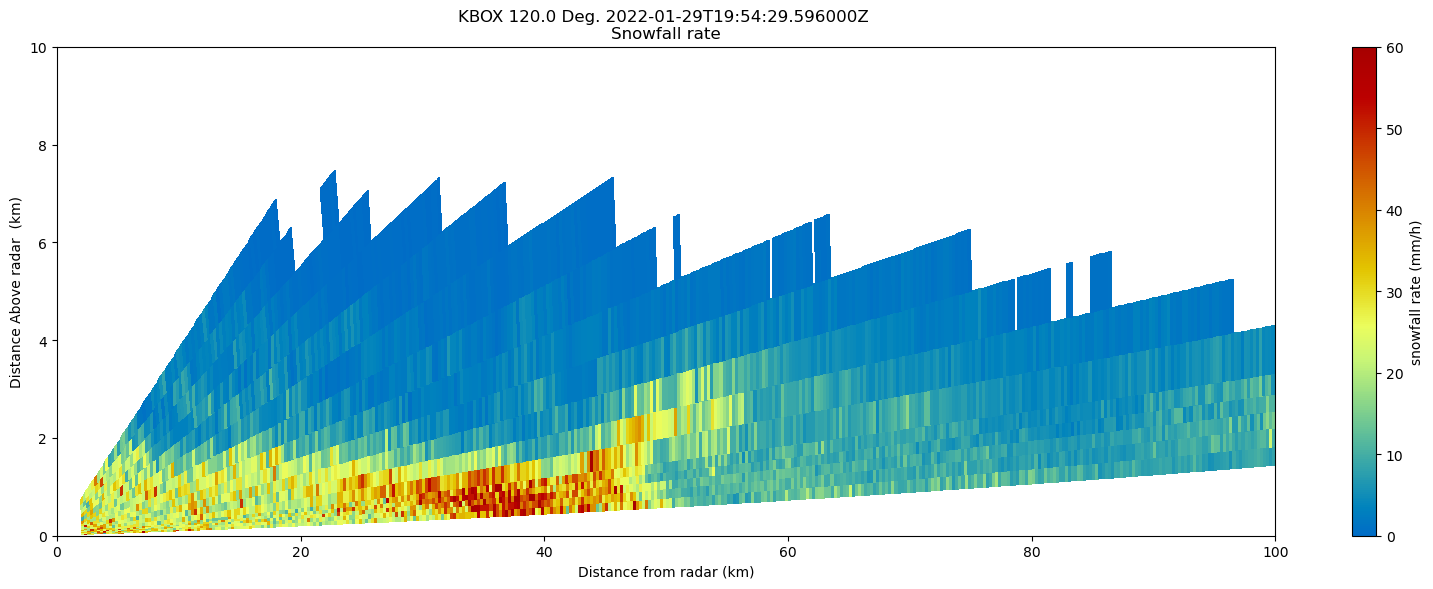

In [15]:
#Make a new radar object, a RHI through the PPI at 120 degrees
xsect = pyart.util.cross_section_ppi(radar, [120])

#Same gig.. Lets plot it! 
display = pyart.graph.RadarDisplay(xsect)
fig = plt.figure(figsize=(16, 6), dpi=100)
display.plot('snow_z', 0, vmin=0, vmax=60., cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
display.set_limits((0, 100), (0, 10))
plt.tight_layout()